In [1]:
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import plot_importance
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx')
data['date'] = pd.to_datetime(data['date'])
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx').dropna(how='any',axis=0)
test_data['date'] = pd.to_datetime(test_data['date'])

In [3]:
data

,date,player,rounds,rating,average_combat_score,kills_deaths,average_damage_per_round,kills_per_round,assists_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths
0,2022-10-07,Cryocells,119,1.22,249.6,1.39,158.8,0.89,0.11,0.15,0.06,0.24,0.06,106,76,13,18,7
1,2022-08-31,Cryocells,285,1.15,232.2,1.27,143.4,0.85,0.13,0.18,0.13,0.24,0.19,242,191,36,50,36
2,2023-02-13,Cryocells,175,1.00,219.3,1.01,137.5,0.75,0.25,0.13,0.18,0.18,0.00,131,130,54,23,32
3,2022-08-31,bang,157,1.04,192.0,1.08,129.1,0.71,0.36,0.07,0.09,0.40,0.29,112,104,56,11,14
4,2023-02-13,bang,175,0.99,200.1,0.98,134.5,0.74,0.34,0.13,0.12,0.39,0.05,129,131,59,22,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022-08-31,yay,492,1.26,254.6,1.50,159.8,0.93,0.09,0.20,0.08,0.26,0.15,460,306,42,96,40
414,2023-02-13,yay,89,1.11,201.6,1.24,127.4,0.75,0.15,0.15,0.12,0.29,0.08,67,54,13,13,11
415,2022-10-04,hoody,128,1.11,242.8,1.08,155.6,0.82,0.30,0.12,0.08,0.30,0.18,105,97,38,15,10
416,2023-02-13,hoody,97,0.96,189.0,0.94,135.4,0.63,0.16,0.06,0.08,0.23,0.20,61,65,16,6,8


In [4]:
# Select features and target variable
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']

target_variable = 'average_combat_score'

In [5]:
#Old Split
'''
X_train = data[features]
X_test = test_data[features]
y_train = data[target_variable]
y_test = test_data[target_variable]
'''
X_test_other = test_data[features]
y_test_other = test_data[target_variable]
None

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state=42)

In [10]:
print(len(X_train))
print(len(X_test))

334
84


In [20]:
X_train

,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths
336,0.68,0.32,123.7,0.05,0.07,0.25,0.35,118,123,56,8,13
31,0.66,0.35,121.7,0.03,0.07,0.29,0.22,146,153,77,7,16
84,0.82,0.29,148.4,0.11,0.04,0.34,0.00,37,32,13,5,2
287,0.63,0.26,118.0,0.07,0.07,0.32,0.18,260,282,107,30,30
317,0.78,0.28,148.0,0.11,0.08,0.30,0.17,174,146,62,25,17
...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.82,0.25,159.1,0.11,0.06,0.28,0.20,312,255,95,42,24
106,0.76,0.24,137.4,0.11,0.13,0.25,0.14,159,148,50,23,27
270,0.82,0.23,158.0,0.19,0.19,0.22,0.05,139,129,39,32,32
348,0.53,0.23,102.1,0.03,0.05,0.17,0.05,58,82,25,3,5


In [ ]:
# Initialize the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test.to_numpy())

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
#With Hyperparameter tuning

In [ ]:
#Create model pipeline
from sklearn.pipeline import Pipeline

estimators = [
    ('clf', XGBRegressor(objective='reg:squarederror', random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)

In [ ]:
#Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=100, scoring='neg_mean_squared_error', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values
# Put final parameters in 4.2.3

In [ ]:
#Train opt

In [ ]:
opt.fit(X_train, y_train)

In [ ]:
#Evaluate the model and make predictions

In [ ]:
opt.best_estimator_

In [ ]:
y_pred = opt.predict(X_test.to_numpy())

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
#Measure feature importance 

In [ ]:
opt.best_estimator_.steps

In [5]:
#Save Models

filename1 = 'model no tune.sav'
filename2 = 'model.sav'

In [ ]:
pickle.dump(model, open(filename1, 'wb'))

In [ ]:
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]

pickle.dump(xgboost_model, open(filename2, 'wb'))

In [6]:
#Load Model

model = pickle.load(open(filename1, 'rb'))
opt = pickle.load(open(filename2, 'rb'))

In [ ]:
opt

In [27]:
# Evaluate the unoptimized model
y_pred = model.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 32.38491847406828
Mean Absolute Percentage Error: 0.02330253455000798
R-squared: 0.9675218963876215


In [29]:
# Evaluate the optimized model
y_pred = opt.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 29.449433682061105
Mean Absolute Percentage Error: 0.021484968393441457
R-squared: 0.9704658278137176


In [32]:
# Evaluate the unoptimized model to other data
y_pred_other = model.predict(X_test_other.to_numpy())
mse_other = mean_squared_error(y_test_other, y_pred_other)
mape_other = mean_absolute_percentage_error(y_test_other, y_pred_other)
r2_other = r2_score(y_test_other, y_pred_other)
print(f'Mean Squared Error: {mse_other}')
print(f'Mean Absolute Percentage Error: {mape_other}')
print(f'R-squared: {r2_other}')

Mean Squared Error: 78.29743571572608
Mean Squared Error: 0.03444894469976452
R-squared: 0.9274915341883713


In [31]:
# Evaluate the model to other data
y_pred_other = opt.predict(X_test_other.to_numpy())
mse_other = mean_squared_error(y_test_other, y_pred_other)
mape_other = mean_absolute_percentage_error(y_test_other, y_pred_other)
r2_other = r2_score(y_test_other, y_pred_other)
print(f'Mean Squared Error: {mse_other}')
print(f'Mean Absolute Percentage Error: {mape_other}')
print(f'R-squared: {r2_other}')

Mean Squared Error: 62.225466027989164
Mean Squared Error: 0.03031193734132893
R-squared: 0.9423752127402443


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

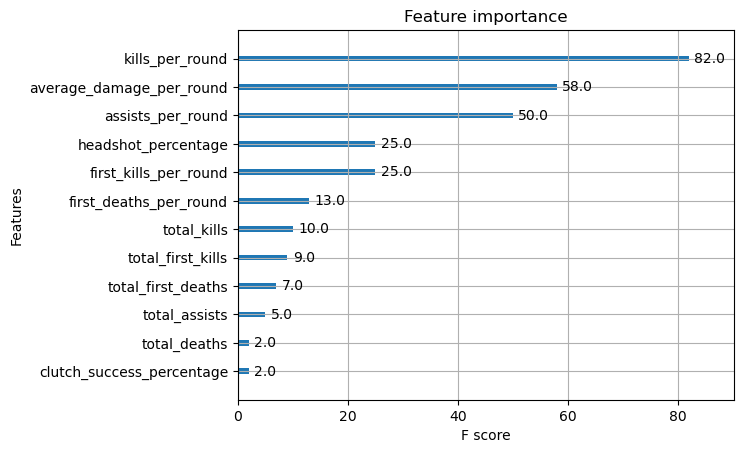

In [10]:
#Predict importance of each feature
plot_importance(opt)

In [ ]:
from pdpbox import pdp
# PDPs show the relationship between a feature and the predicted outcome while keeping other features constant. 
# Create PDP for a specific feature
pdp_feature = pdp.pdp_isolate(opt, X_train, X_train.columns, feature='kills_per_round')
pdp.pdp_plot(pdp_feature, 'kills_per_round')
plt.show()

In [ ]:
#Predict and analyze models

In [17]:
predictions = model.predict(X_test)
predictions_optimized = opt.predict(X_test)

In [18]:
y_pred = opt.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Squared Error: {mape}')

Mean Squared Error: 29.449433682061105
Mean Squared Error: 0.021484968393441457


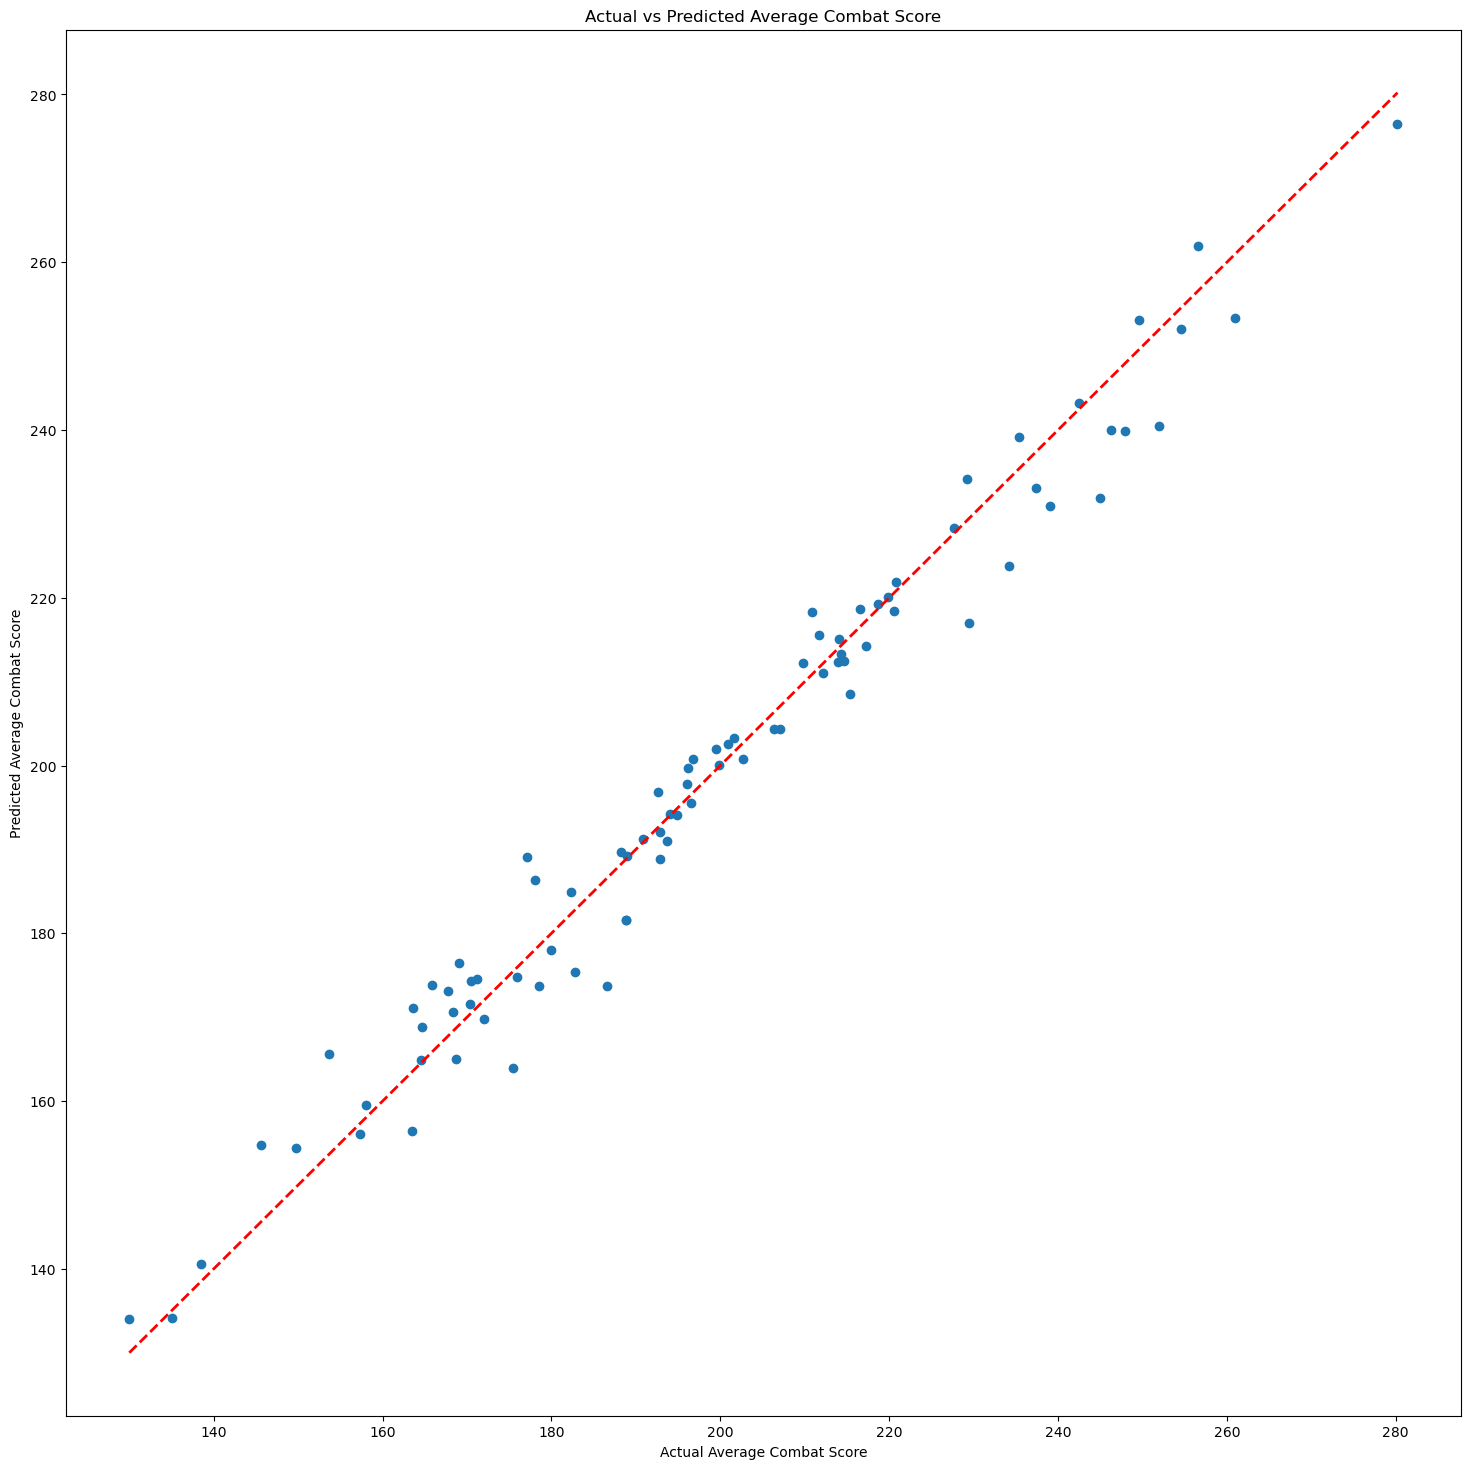

In [19]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(y_test, predictions_optimized)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [ ]:
#Residual Plot
residuals = y_test - predictions_optimized
plt.scatter(predictions_optimized, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
#Distribution of Residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [ ]:
# Actual vs Predicted graph player's highest ACS

df_model_predict = data.assign(predictions = opt.predict(data[features]))
df_only_first = df_model_predict.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')

actual = df_only_first['average_combat_score']
high_predictions = df_only_first['predictions']

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(actual, high_predictions)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Highest Average Combat Score")
plt.ylabel("Predicted Highest Average Combat Score")
plt.title("Actual vs Predicted Highest Average Combat Score")

# Display player names with a larger offset
for row in df_only_first.itertuples():
    # Add a larger offset to player names
    offset = 10  # Adjust this value based on your preference
    plt.annotate(row.player, (row.average_combat_score, row.predictions), textcoords="offset points", xytext=(0, offset))

# Show the larger plot
plt.show()

In [3]:
# Selected important variables

In [4]:
# Select features and target variable
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'clutch_success_percentage', 'headshot_percentage']

target_variable = 'average_combat_score'

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state=42)

In [6]:
print(len(X_train))
print(len(X_test))

334
84


In [42]:
# Initialize the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [43]:
# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [44]:
# Make predictions on the test set
y_pred = model.predict(X_test.to_numpy())

In [46]:
#Check stats 
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-Squared: {r2}')

Mean Squared Error: 37.16915315867756
Mean Absolute Percentage Error: 0.023842036824995527
R-Squared: 0.9627238954318033


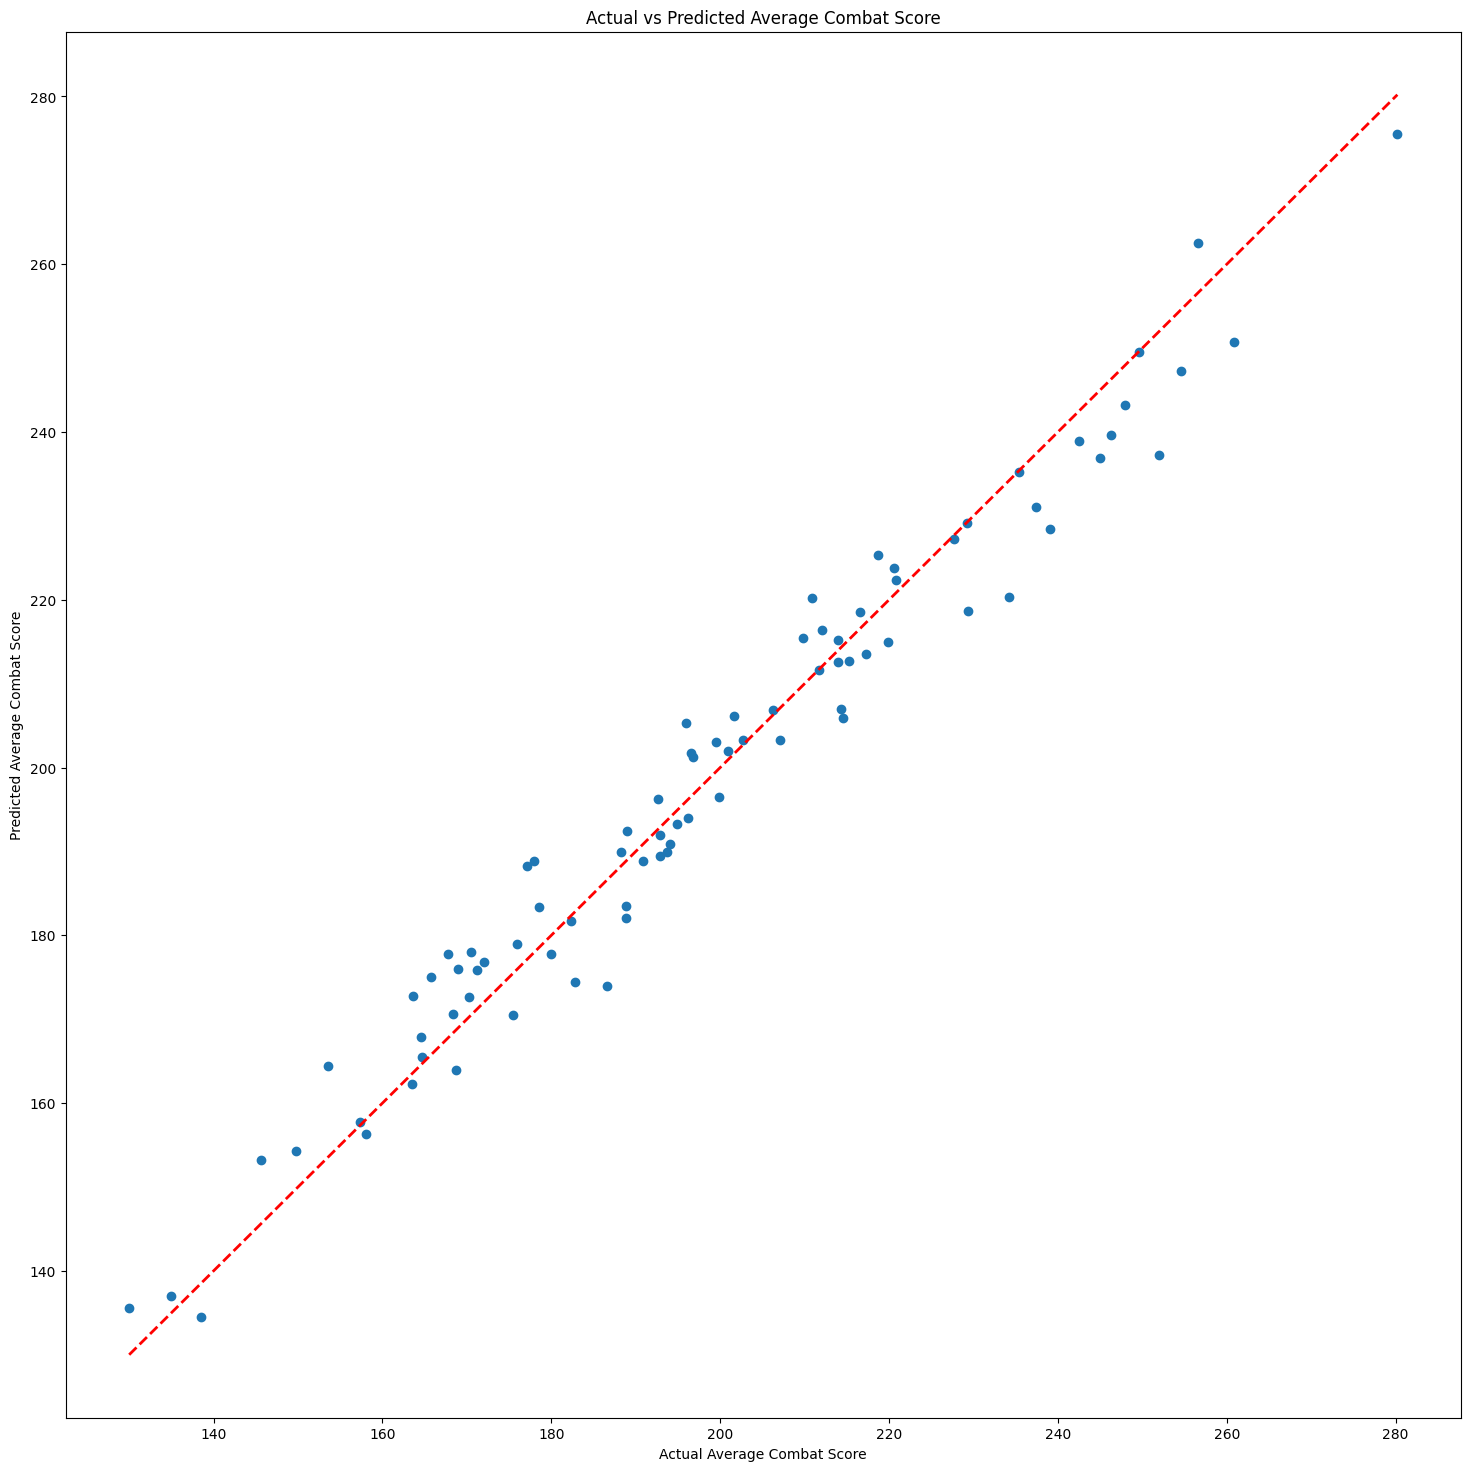

In [11]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

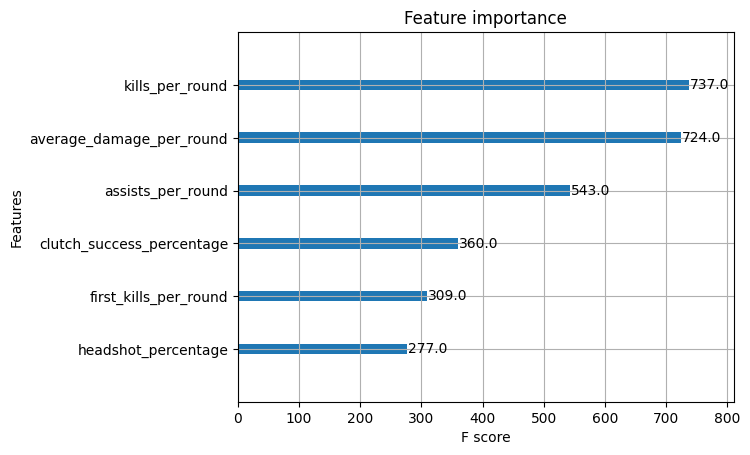

In [47]:
#Predict importance of each feature
plot_importance(model)

In [48]:
#Create an Anova Table
df_X_train = X_train.copy()
df_X_train['target'] = y_train
# Step 5: Fit a linear regression model using statsmodels
model_OLS = sm.OLS.from_formula('target ~ ' + ' + '.join(df_X_train.columns[:-1]), data=df_X_train)
result = model_OLS.fit()

In [49]:
anova_table = sm.stats.anova_lm(result)
print(anova_table)

                              df         sum_sq        mean_sq            F  \
kills_per_round              1.0  305291.998012  305291.998012  8322.982465   
assists_per_round            1.0     760.994009     760.994009    20.746498   
average_damage_per_round     1.0   11644.876133   11644.876133   317.466886   
first_kills_per_round        1.0    1915.970580    1915.970580    52.233893   
clutch_success_percentage    1.0      57.577695      57.577695     1.569704   
headshot_percentage          1.0     879.075104     879.075104    23.965668   
Residual                   327.0   11994.556490      36.680601          NaN   

                                  PR(>F)  
kills_per_round            1.200103e-234  
assists_per_round           7.409986e-06  
average_damage_per_round    4.178248e-50  
first_kills_per_round       3.500623e-12  
clutch_success_percentage   2.111452e-01  
headshot_percentage         1.543512e-06  
Residual                             NaN  


In [50]:
anova_table_pd = pd.DataFrame(anova_table)

In [51]:
anova_table_pd.sort_values('PR(>F)')

,df,sum_sq,mean_sq,F,PR(>F)
kills_per_round,1.0,305291.998012,305291.998012,8322.982465,1.200103e-234
average_damage_per_round,1.0,11644.876133,11644.876133,317.466886,4.178248e-50
first_kills_per_round,1.0,1915.970580,1915.970580,52.233893,3.500623e-12
headshot_percentage,1.0,879.075104,879.075104,23.965668,1.543512e-06
assists_per_round,1.0,760.994009,760.994009,20.746498,7.409986e-06
clutch_success_percentage,1.0,57.577695,57.577695,1.569704,2.111452e-01
Residual,327.0,11994.556490,36.680601,NaN,NaN


C:\Users\adban\anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


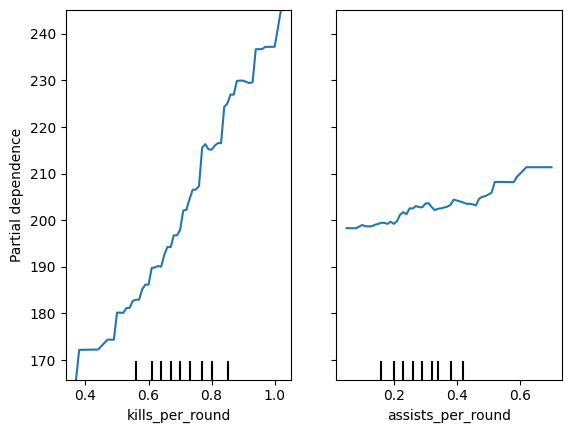

In [52]:
# Compute partial dependence
features_to_plot = [0, 1]
pdp_results = partial_dependence(model, X_train, features=features_to_plot)

# Create PartialDependenceDisplay object
pdp_display = PartialDependenceDisplay.from_estimator(model, X_train, features=features_to_plot)

<Figure size 2000x1000 with 0 Axes>

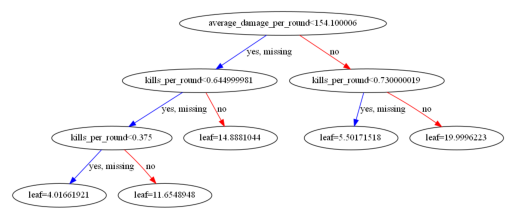

In [53]:
# Visualize the tree in the ensemble
# This requires the python-graphviz library.
plt.figure(figsize=(20, 10))
plot_tree(model, num_trees=4, rankdir='UT')  # num_trees specifies the tree index
plt.show()

In [7]:
#Create model pipeline
from sklearn.pipeline import Pipeline

estimators = [
    ('clf', XGBRegressor(objective='reg:squarederror', random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)

In [8]:
#Set up hyperparameter tuning


search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

In [13]:
opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=15, scoring='neg_mean_squared_error', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values
# Put final parameters in 4.2.3

In [14]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('clf',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                

In [11]:
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=1.0, colsample_bynode=1.0,
                              colsample_bytree=0.5, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=10.0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.08928673529810434, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                   

In [16]:
hyperparams = opt.cv_results_['params']
scores = opt.cv_results_['mean_test_score']

In [19]:
opt.cv_results_['mean_test_score']

array([-33847.45923496, -25475.44971072, -23029.0372542 ,   -130.52261711,
         -101.99239731,  -9927.77345707,  -2716.99608133,   -473.14683168,
       -11907.56423718,    -83.31806662,    -64.38538716,    -74.1025564 ,
          -90.02979464,    -62.47500839,    -73.90701754,    -70.30831126,
          -60.9439204 ,    -57.60049401,    -75.63070557,    -62.00941813,
          -56.52114333,    -66.80953029,   -125.77879668,    -57.35976994,
          -52.60416128,    -55.31606503,    -64.23779251,    -62.56607722,
          -53.12584766,    -51.05138519,    -55.93769811,   -115.07774772,
          -53.16846792,    -49.85472508,    -63.44536653,    -85.5637552 ,
          -62.20633601,    -82.20680155,    -77.45318165,    -54.45067831,
          -52.3647227 ,    -53.66549982,    -51.01279374,    -63.88392309,
          -50.04488668,    -72.0575091 ,    -51.46601442,    -50.58595055,
         -163.30599303,    -67.04880089,    -52.60521488,    -58.21975635,
          -51.17575447,  

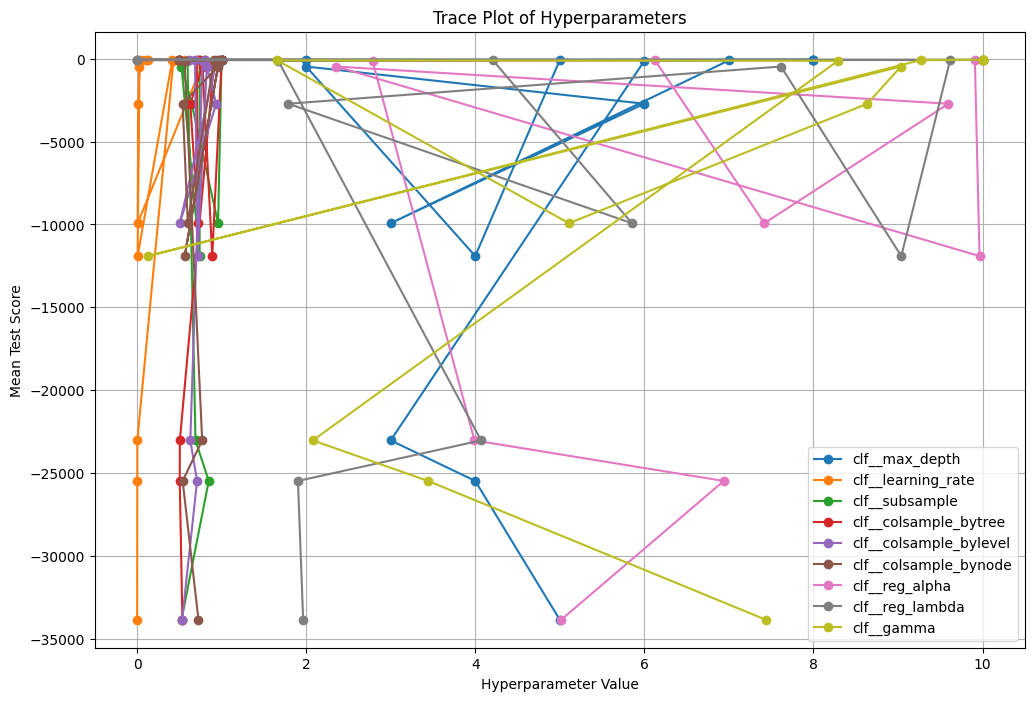

In [17]:
# Plot the trace plots for each hyperparameter
plt.figure(figsize=(12, 8))
for param in search_space.keys():
    param_values = [x[param] for x in hyperparams]
    plt.plot(param_values, scores, marker='o', linestyle='-', label=param)

plt.title('Trace Plot of Hyperparameters')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

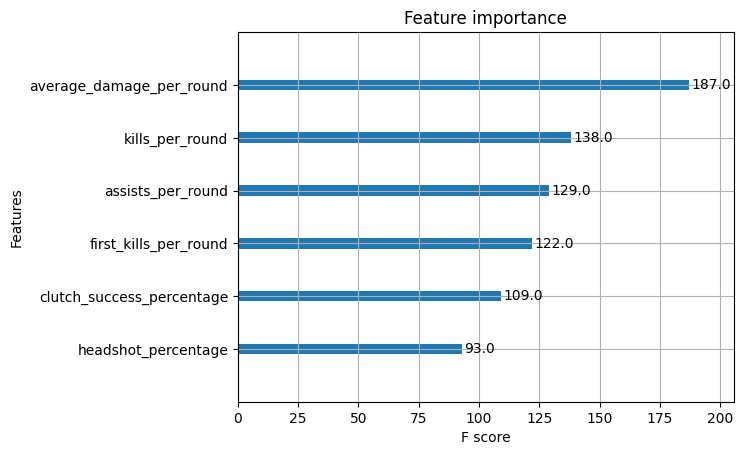

In [18]:
#Predict importance of each feature
plot_importance(xgboost_model)

In [19]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test.to_numpy())

In [20]:
#Check stats 
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-Squared: {r2}')

Mean Squared Error: 36.91341306365895
Mean Absolute Percentage Error: 0.024159882819135
R-Squared: 0.9629803713994826


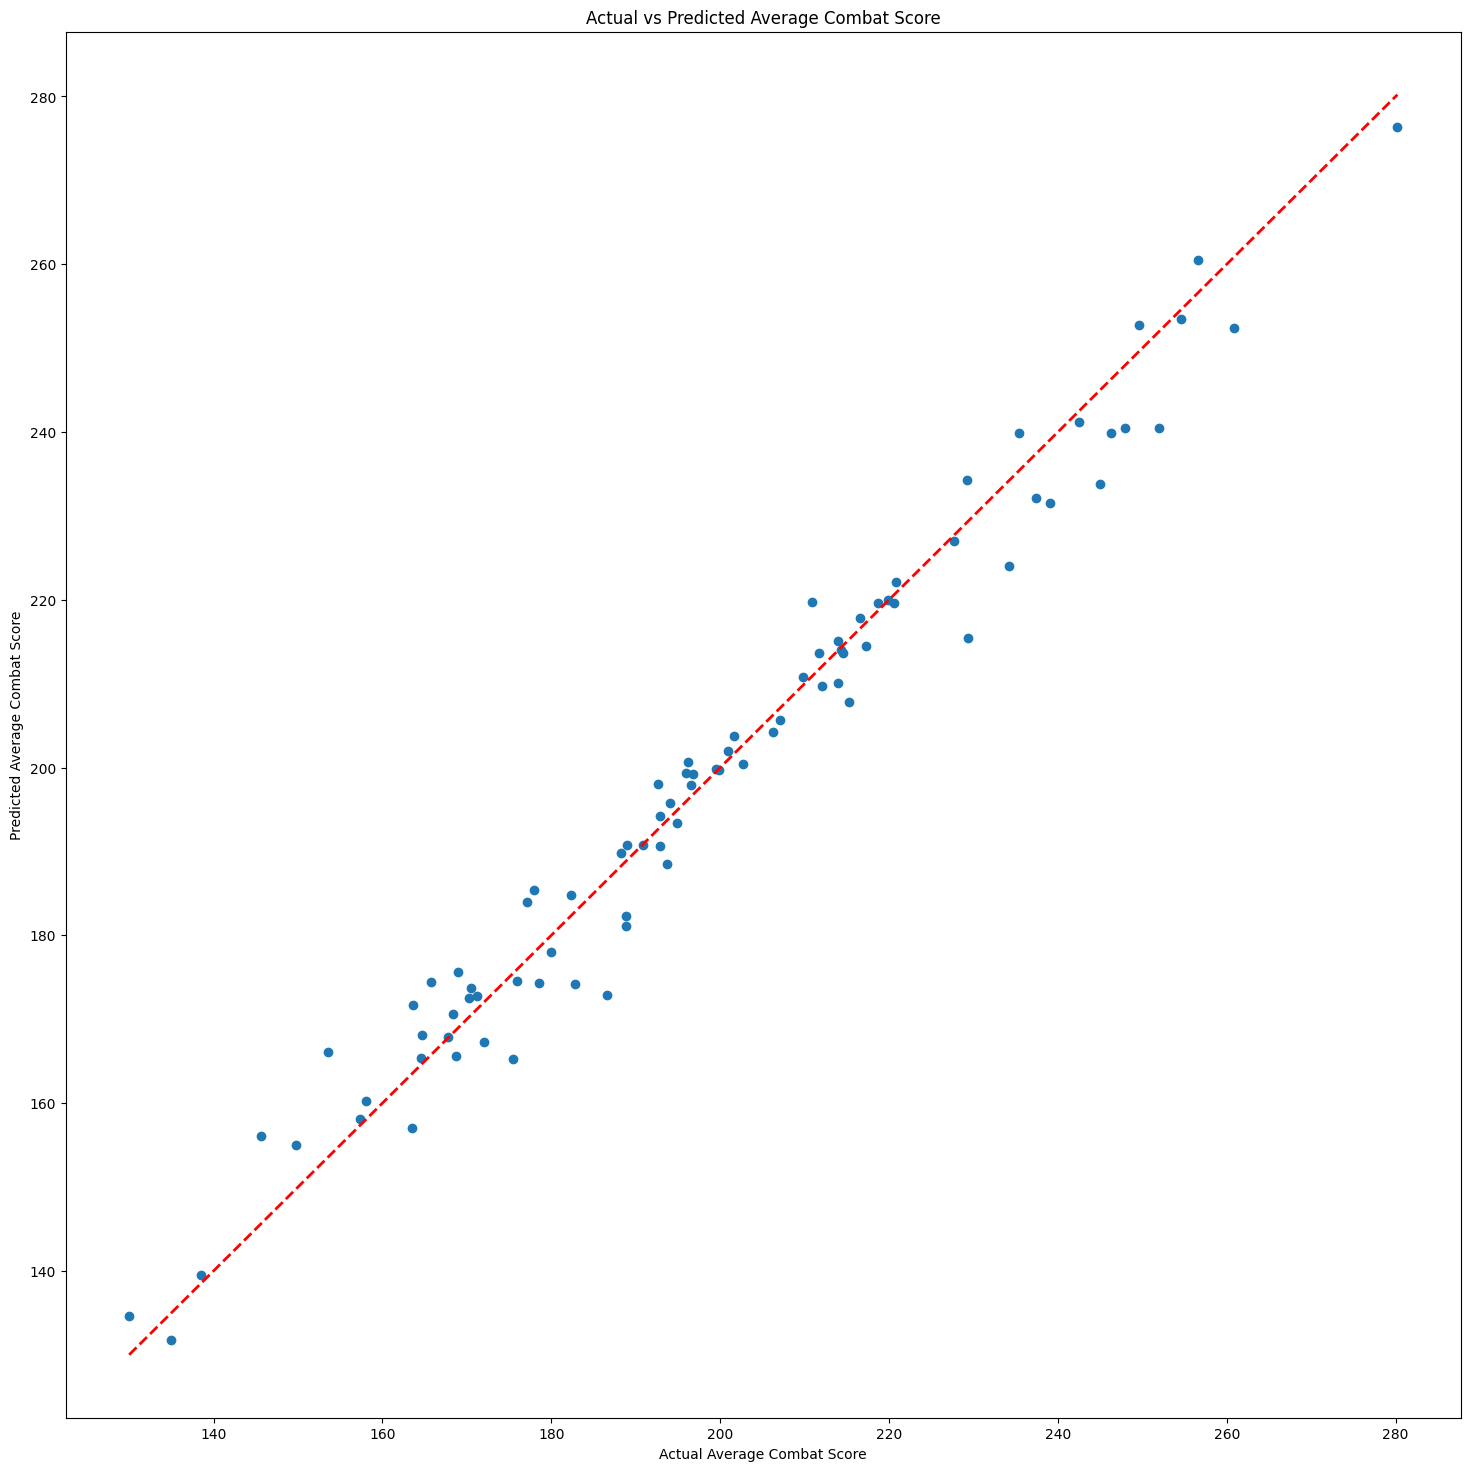

In [62]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

C:\Users\adban\anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


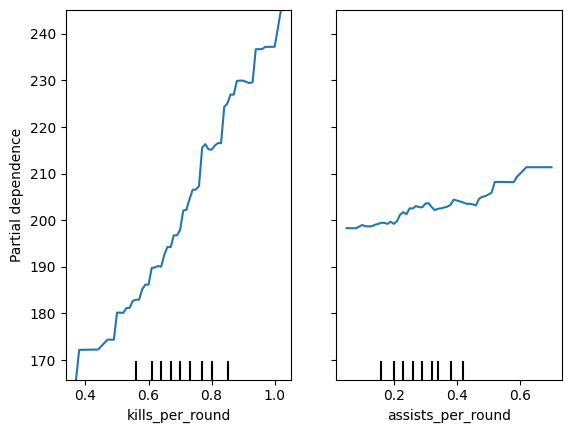

In [63]:
# Compute partial dependence
features_to_plot = [0, 1]
pdp_results = partial_dependence(xgboost_model, X_train, features=features_to_plot)

# Create PartialDependenceDisplay object
pdp_display = PartialDependenceDisplay.from_estimator(model, X_train, features=features_to_plot)

<Figure size 2000x1000 with 0 Axes>

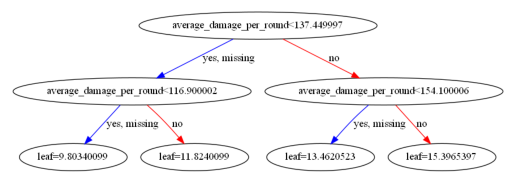

In [64]:
# Visualize the tree in the ensemble
# This requires the python-graphviz library.
plt.figure(figsize=(20, 10))
plot_tree(xgboost_model, num_trees=4, rankdir='UT')  # num_trees specifies the tree index
plt.show()

In [10]:
#Save Models

filename1 = 'model no tune new.sav'
filename2 = 'model new.sav'
filename3 = 'models new.sav'

In [67]:
pickle.dump(model, open(filename1, 'wb'))
pickle.dump(xgboost_model, open(filename2, 'wb'))

In [ ]:
pickle.dump(opt, open(filename3, 'wb'))

In [11]:
opt = pickle.load(open(filename3, 'rb'))

In [ ]:
xgboost_model = pickle.load(open(filename2, 'rb'))

In [15]:
model = pickle.load(open(filename1, 'rb'))

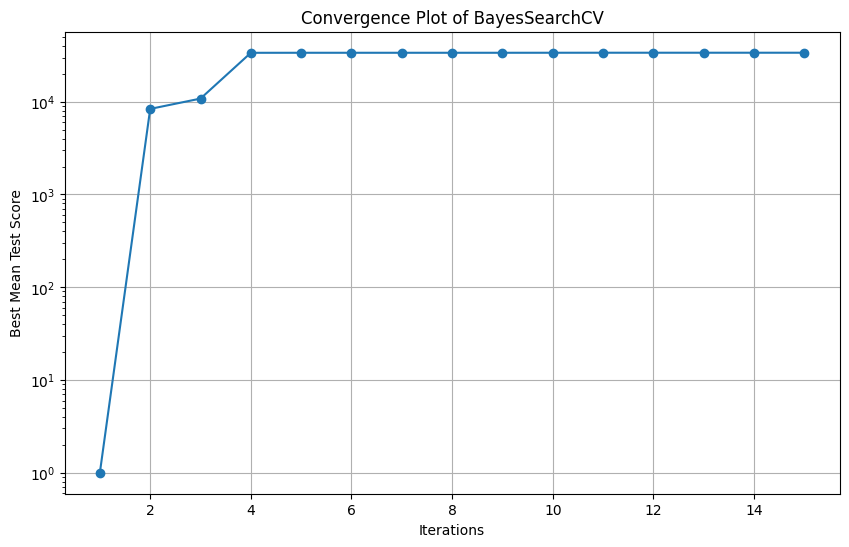

In [18]:
import numpy as np
# Extract the best scores found so far across iterations
best_scores = -np.inf
best_scores = [max(opt.cv_results_['mean_test_score'][:i+1]) for i in range(len(opt.cv_results_['mean_test_score']))]

min_score = min(best_scores)
if min_score <= 0:
    constant = abs(min_score) + 1
else:
    constant = 1
best_scores = [score + constant for score in best_scores]

# Plot the convergence plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='o', linestyle='-')
plt.yscale('log')
plt.title('Convergence Plot of BayesSearchCV')
plt.xlabel('Iterations')
plt.ylabel('Best Mean Test Score')
plt.grid(True)
plt.show()

In [32]:
opt.cv_results_['mean_test_score'][9:]

array([ -83.31806662,  -64.38538716,  -74.1025564 ,  -90.02979464,
        -62.47500839,  -73.90701754,  -70.30831126,  -60.9439204 ,
        -57.60049401,  -75.63070557,  -62.00941813,  -56.52114333,
        -66.80953029, -125.77879668,  -57.35976994,  -52.60416128,
        -55.31606503,  -64.23779251,  -62.56607722,  -53.12584766,
        -51.05138519,  -55.93769811, -115.07774772,  -53.16846792,
        -49.85472508,  -63.44536653,  -85.5637552 ,  -62.20633601,
        -82.20680155,  -77.45318165,  -54.45067831,  -52.3647227 ,
        -53.66549982,  -51.01279374,  -63.88392309,  -50.04488668,
        -72.0575091 ,  -51.46601442,  -50.58595055, -163.30599303,
        -67.04880089,  -52.60521488,  -58.21975635,  -51.17575447,
        -55.88842608,  -56.75383581,  -53.47785624,  -53.32126281,
        -51.38169546,  -62.92071998,  -52.65227538,  -52.10273239,
        -67.0875078 ,  -53.64999545,  -52.39124039,  -55.28580234,
        -51.56804371,  -54.81220626,  -54.61826331,  -53.25606

In [14]:
xgboost_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 10.0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.08928673529810434,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 8,
 'reg_alpha': 10.0,
 'reg_lambda': 0.0,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1.0,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [16]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}